## Live Case:
### Group 8

#### Objective

The primary objective of this analysis is to evaluate county-level performance across various agricultural and economic data types over two distinct census years (2017 and 2022). The analysis aims to quantify performance trends by employing quartile-based segmentation and longitudinal analysis of consistency within performance categories. This approach will facilitate identifying counties that demonstrate stable, improving, or declining performance trends over time.

#### Approach

The analytical methodology is structured into three critical stages: Data Filtering, Quartile Segmentation, and Trend Analysis.
1. Data Filtering
The initial phase involves a rigorous data preprocessing pipeline to ensure analytical accuracy and relevance:
Metric Selection: Filter data where the Data_Item field includes the phrase "MEASURED IN Sales" to isolate sales-related metrics. This ensures a consistent financial basis for performance evaluation.
Data Standardization: The Value column is cleaned and converted to a numeric data type using data imputation techniques for handling missing values (e.g., replacing suppression codes with NaN).
Outlier Detection: Apply z-score analysis or IQR (Interquartile Range) method to detect and handle outliers that could skew quartile calculations.
Normalization: Implement Min-Max Scaling or Standardization (z-score transformation) to normalize the sales values, enhancing comparability across counties with different scales of sales activities.
2. Quartile Segmentation
This stage involves the statistical stratification of counties into performance-based quartiles:
Grouping Criteria: The data is grouped by County, Type (e.g., Animals, Crops, Demographics, Economics), and Year (2017 and 2022).
Aggregation Method: Compute the sum of sales for each county and type to generate a comprehensive performance score. This step could be extended with additional aggregate functions (e.g., mean, median, standard deviation) for deeper insights.
Quartile Division: Segment counties into quartiles using percentile-based thresholds:
0-25% (Q1): Lowest-performing counties (1st quartile).
25-50% (Q2): Below-average performers (2nd quartile).
50-75% (Q3): Above-average performers (3rd quartile).
75-100% (Q4): Top-performing counties (4th quartile).
Descriptive Statistics: Calculate central tendency (mean, median) and dispersion metrics (variance, standard deviation) within each quartile to summarize performance distribution.
Visualization: Generate box plots, histograms, and violin plots to visualize sales value distributions and quartile boundaries.
3. Trend Analysis (Common Counties)
This step focuses on longitudinal analysis of county performance consistency:
Inter-Year Comparison: Identify counties that remain in the same quartile across both years for each type.
Trend Consistency: Use Cohen’s Kappa or Weighted Kappa to measure agreement between categorical classifications of counties in 2017 and 2022, assessing trend stability.
Transition Matrix: Create a transition matrix to visualize movement between quartiles, showing how many counties improved, declined, or maintained their performance category.
Statistical Testing: Conduct chi-square tests to evaluate whether changes in quartile distribution are statistically significant, distinguishing between random variation and meaningful trends.
Correlation Analysis: Apply Spearman's Rank Correlation to evaluate the monotonic relationship between county rankings in 2017 and 2022.
Outcome

The expected outcomes of this analysis include:
Filtered Dataset: A cleaned and sales-focused dataset for the years 2017 and 2022.
Quartile Analysis: A clear segmentation of counties based on performance with robust statistical summaries for each quartile.
Trend Insights: Identification of counties with consistent performance trends, supported by quantitative metrics like stability indices and statistical significance tests.
Visualizations: Intuitive charts and graphs (e.g., heatmaps, trend lines) to support findings.
Assumptions

The analysis is built upon the following assumptions:
Data Completeness: The dataset is assumed to be a representative sample of the agricultural and economic landscape of the counties under study.
Stationarity of Trends: Counties appearing in the same quartile for both years are presumed to have maintained similar performance trends over time. However, this assumption will be tested using time series stability metrics.
Normal Distribution: When applying parametric statistical tests, data within each quartile is assumed to approximate a normal distribution, or non-parametric alternatives will be used otherwise.

In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Load the dataset
file_path = "C:\\Users\\91788\\Downloads\\live_case_data (2).csv"
data = pd.read_csv(file_path)

# Filter rows where 'data_item_description' contains "MEASURED IN $"
data = data[data['Data_Item'].str.contains("MEASURED IN \$")]

# Step 1: Replace non-numeric placeholders like "(D)" with NaN
data['Value'] = data['Value'].replace({'(D)': None})

# Step 2: Remove commas or other formatting issues
data['Value'] = data['Value'].str.replace(',', '')

# Step 3: Convert to numeric
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')

#Step 4: County to Upper 
data['County'] = data['County'].str.strip().str.upper()


# Filter data for 2017 and 2022
data_2017 = data[data['Year'] == 2017]
data_2022 = data[data['Year'] == 2022]


In [2]:
#Debug
#data[(data['County'] == 'HENNEPIN') & (data['Type'] == 'Animals')]

In [3]:
# Function to divide data by type and aggregate values by County
def aggregate_by_type(data):
    types = data['Type'].unique()
    type_datasets = {t: data[data['Type'] == t] for t in types}
    aggregated_results = {
        t: df.groupby(['County', 'Type'], as_index=False)['Value'].sum() for t, df in type_datasets.items()
    }
    return aggregated_results

# Aggregating data for both years
aggregated_results_2017 = aggregate_by_type(data_2017)
aggregated_results_2022 = aggregate_by_type(data_2022)

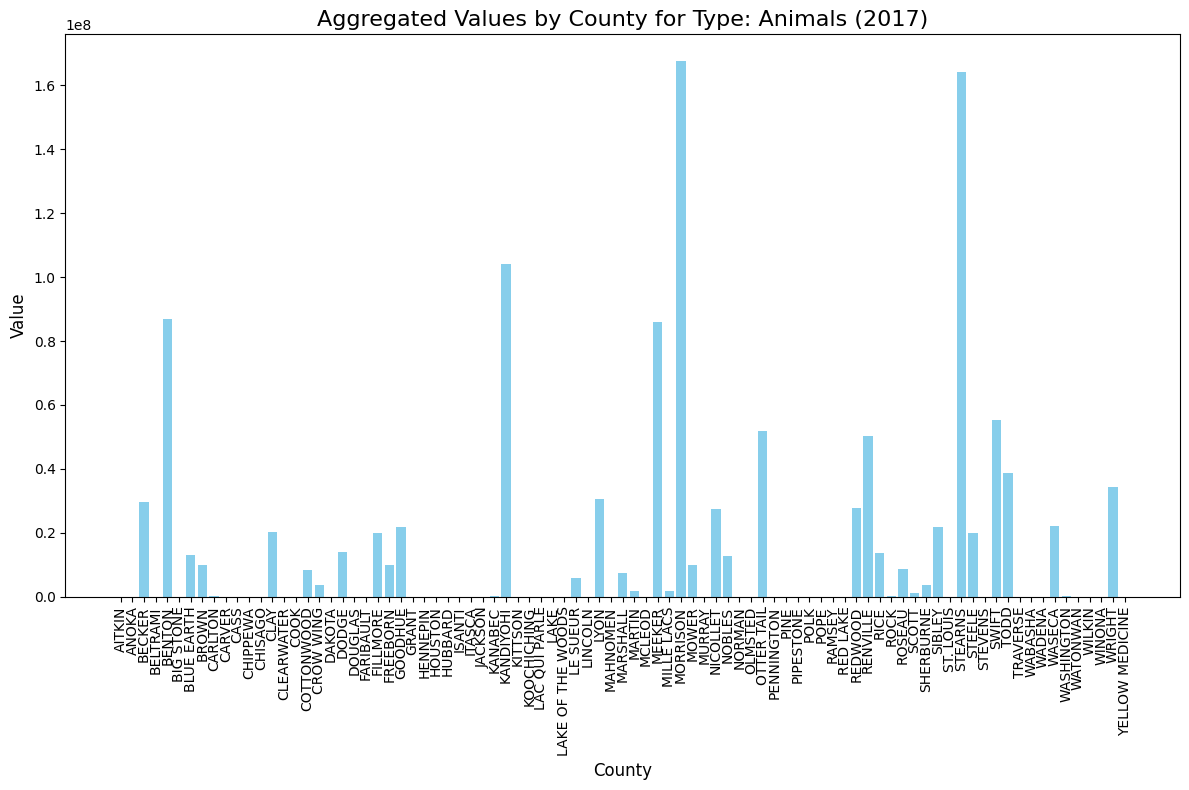

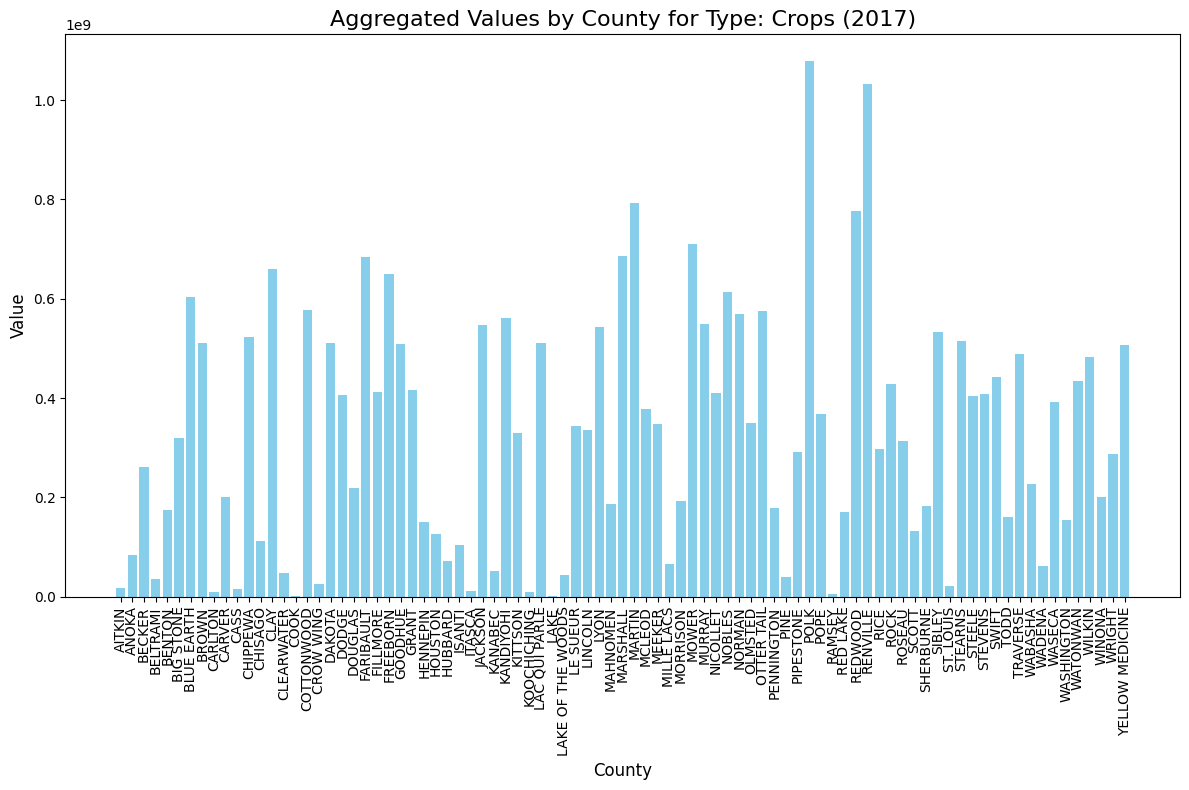

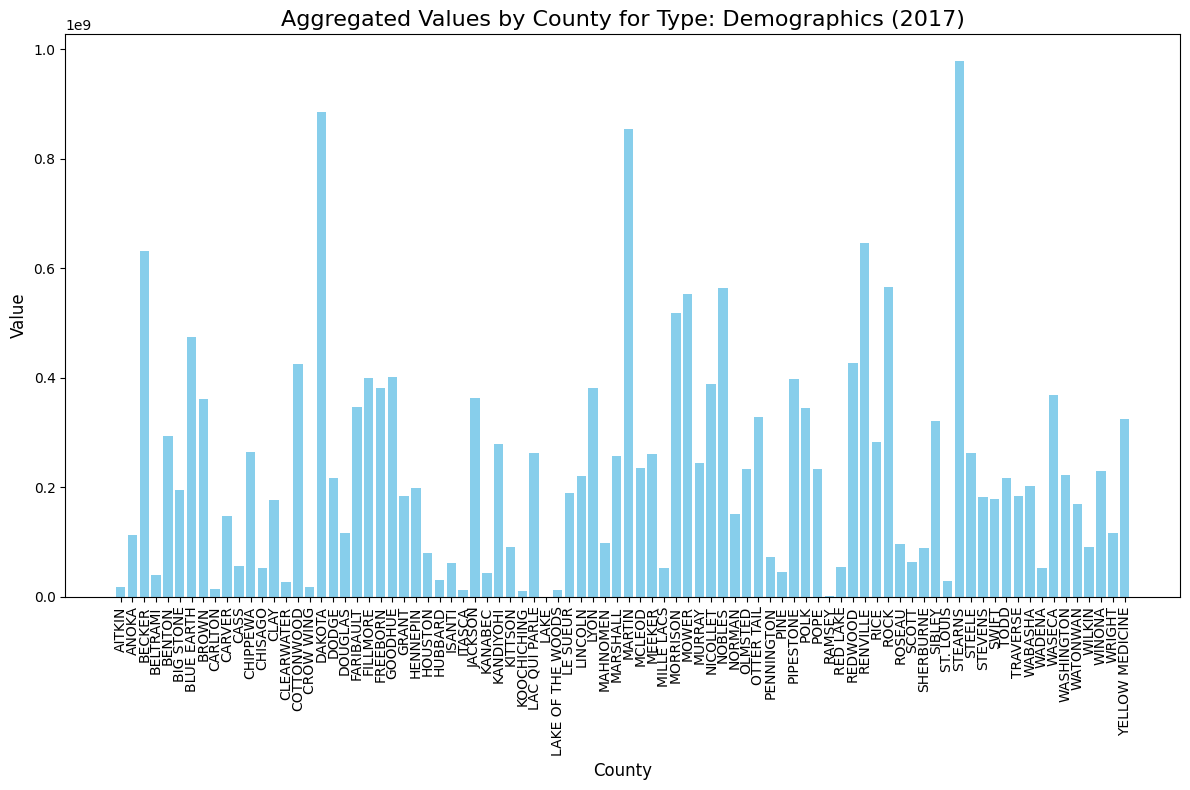

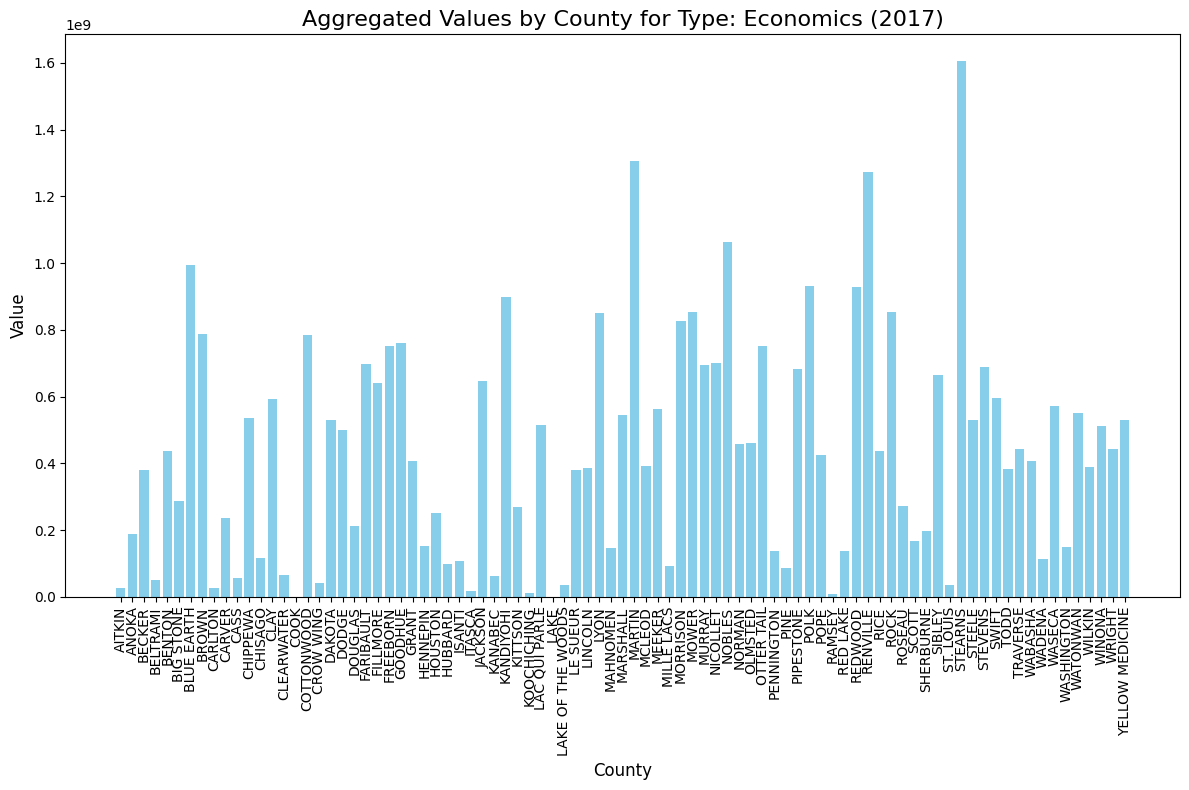

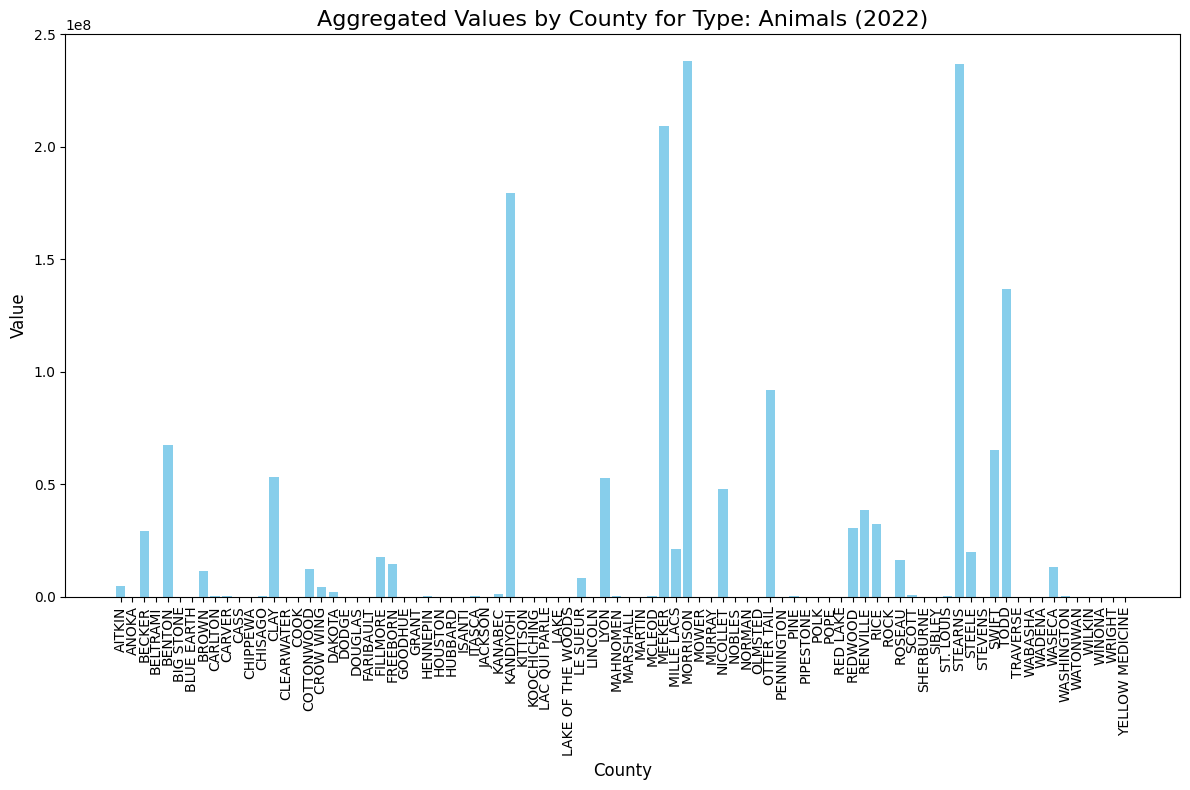

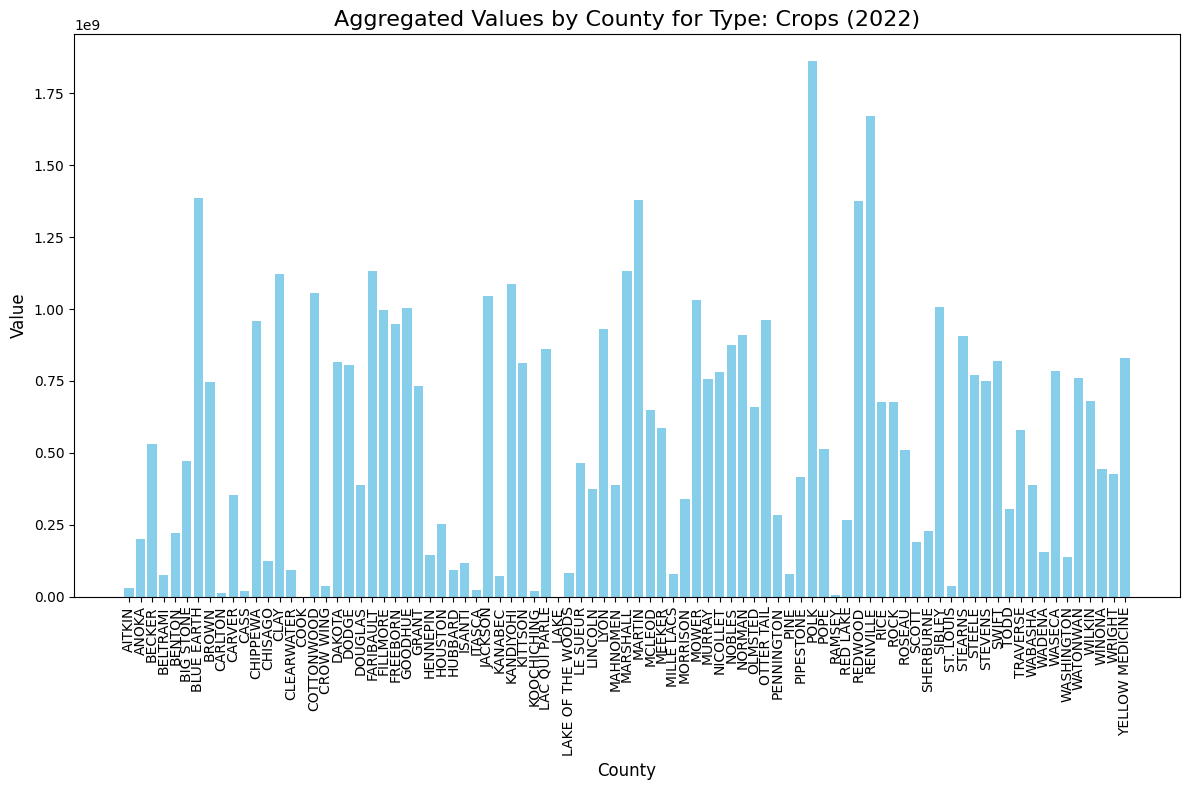

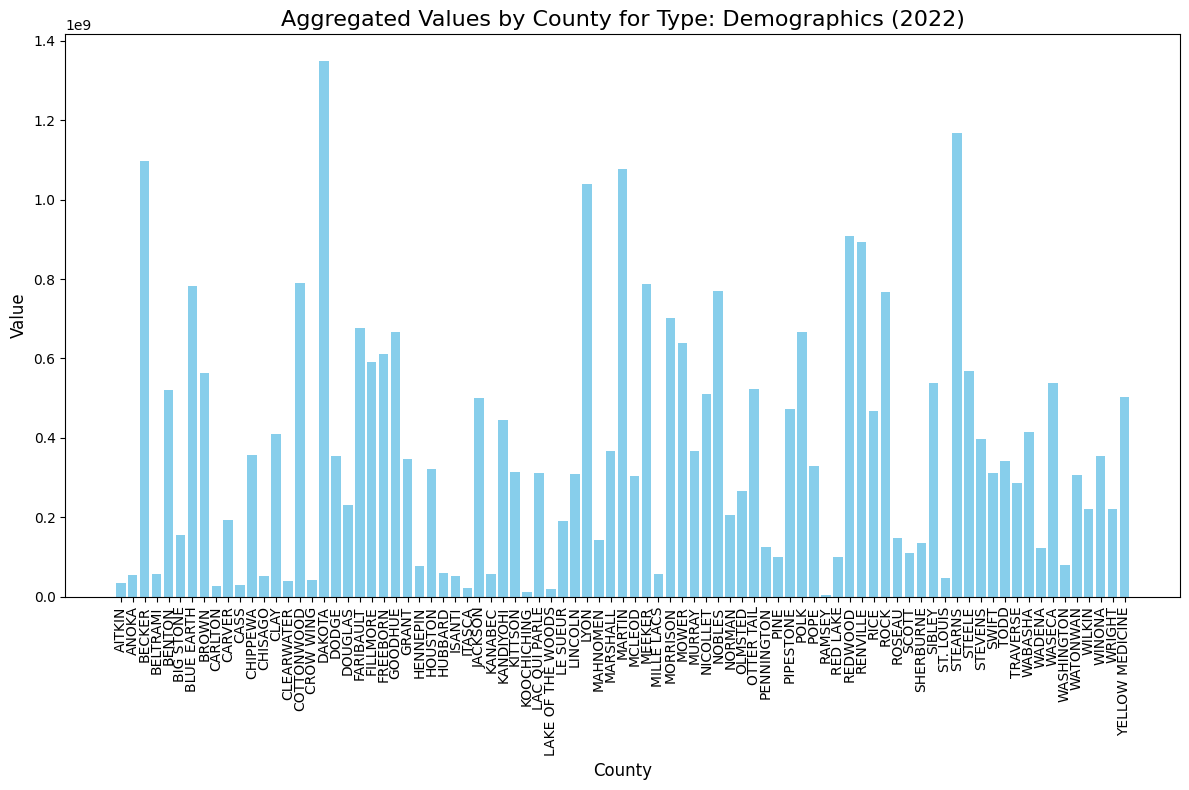

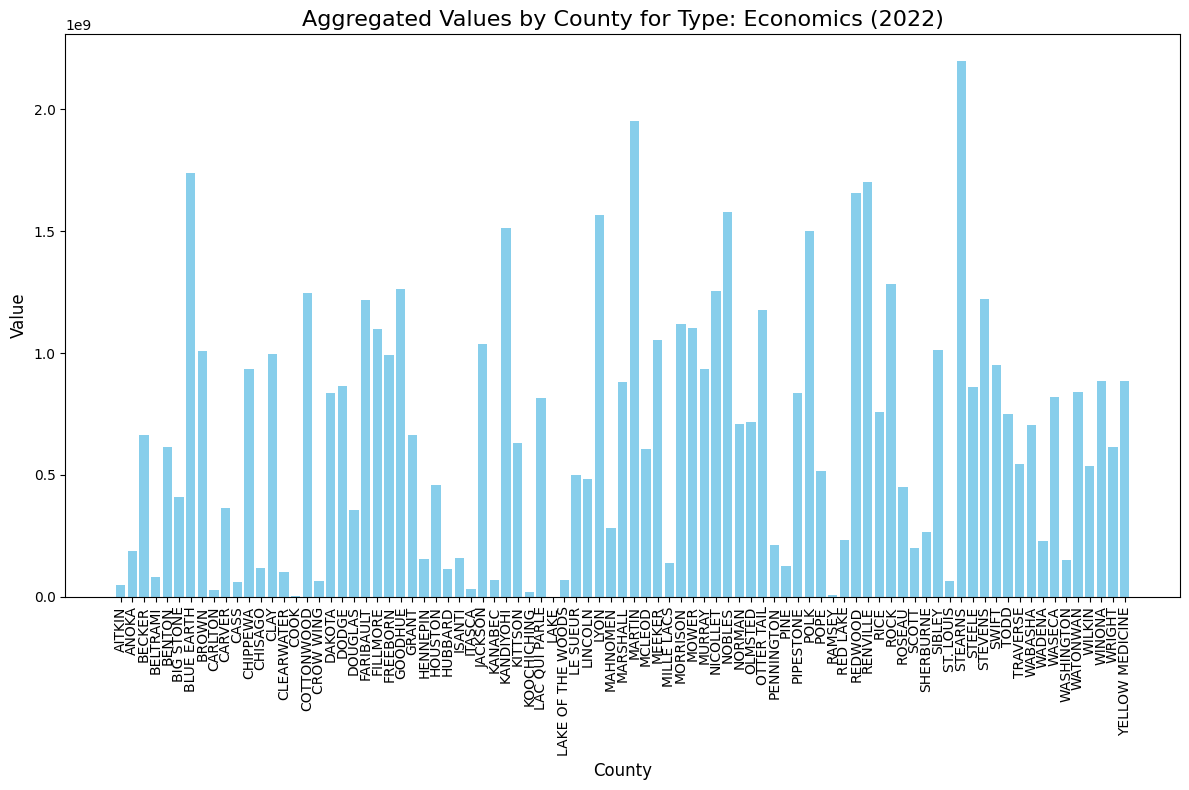

In [4]:
# Function to visualize aggregated data for each type
def plot_aggregated_data(aggregated_results, year):
    for data_type, aggregated_data in aggregated_results.items():
        plt.figure(figsize=(12, 8))
        plt.bar(aggregated_data['County'], aggregated_data['Value'], color='skyblue')
        plt.title(f'Aggregated Values by County for Type: {data_type} ({year})', fontsize=16)
        plt.xlabel('County', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.xticks(rotation=90, fontsize=10)
        plt.tight_layout()
        plt.show()

# Visualizing data for 2017 and 2022
plot_aggregated_data(aggregated_results_2017, 2017)
plot_aggregated_data(aggregated_results_2022, 2022)

In [5]:
# Function to divide data into groups based on thresholds
def divide_into_groups(aggregated_results, thresholds):
    group_results = {f"{int(thresholds[i]*100)}-{int(thresholds[i+1]*100)}": {} for i in range(len(thresholds) - 1)}
    for data_type, aggregated_data in aggregated_results.items():
        for i in range(len(thresholds) - 1):
            lower, upper = thresholds[i], thresholds[i+1]
            threshold_lower = aggregated_data['Value'].quantile(lower)
            threshold_upper = aggregated_data['Value'].quantile(upper)
            
            # Filter rows within the threshold range
            group = aggregated_data[
                (aggregated_data['Value'] >= threshold_lower) & (aggregated_data['Value'] <= threshold_upper)
            ].copy()
            
            # Sort the results by Value in descending order
            group = group.sort_values(by='Value', ascending=False)
            
            # Store the results
            group_results[f"{int(lower*100)}-{int(upper*100)}"][data_type] = group
    
    return group_results

# Define thresholds for quartiles
thresholds = [0.0, 0.25, 0.5, 0.75, 1.0]

# Divide data for 2017 and 2022
grouped_results_2017 = divide_into_groups(aggregated_results_2017, thresholds)
grouped_results_2022 = divide_into_groups(aggregated_results_2022, thresholds)


In [6]:
# Function to segregate quartiles into separate variables
def segregate_quartiles(grouped_results):
    quartile_vars = {}
    for quartile_range, data_by_type in grouped_results.items():
        for data_type, df in data_by_type.items():
            # Create a unique key for each quartile and year
            key = f"{quartile_range}_{data_type}"
            quartile_vars[key] = df
    return quartile_vars

# Segregate quartiles for 2017 and 2022
quartile_vars_2017 = segregate_quartiles(grouped_results_2017)
quartile_vars_2022 = segregate_quartiles(grouped_results_2022)


# Debugging code
import pandas as pd
import os
os.chdir("C:\\Users\\91788\\Downloads")
### Function to save quartile data to Excel
def save_quartiles_to_excel(quartile_vars, filename):
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for key, df in quartile_vars.items():
            # Save each quartile to a separate sheet
            sheet_name = key[:31]  # Limit sheet name to 31 characters (Excel's limit)
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    print(f"Quartile data saved to {filename}")

### Save 2017 quartiles to an Excel file
#save_quartiles_to_excel(quartile_vars_2017, "Quartile_Variables_2017.xlsx")

### Save 2022 quartiles to an Excel file
#save_quartiles_to_excel(quartile_vars_2022, "Quartile_Variables_2022.xlsx")

#### Printn Keys for Debugging
print("Keys in quartile_vars_2017:", quartile_vars_2017.keys())
print("Keys in quartile_vars_2022:", quartile_vars_2022.keys())




key_2017 = "50-75_Crops"  # Correct range
key_2022 = "50-75_Crops"  # Correct range

#### Check if the key exists in both dictionaries
if key_2017 in quartile_vars_2017 and key_2022 in quartile_vars_2022:
    print(f"2017 {key_2017} DataFrame:")
    print(quartile_vars_2017[key_2017])

    print(f"2022 {key_2022} DataFrame:")
    print(quartile_vars_2022[key_2022])
else:
    print(f"Key {key_2017} or {key_2022} not found in quartile data.")

# Debugging code ends





In [7]:
def compare_quartiles_debug(quartile_vars_2017, quartile_vars_2022):
    common_results = {}

    for quartile_range in ['0-25', '25-50', '50-75', '75-100']:
        common_quartile = {}

        for data_type in ['Animals', 'Crops', 'Demographics', 'Economics']:
            key_2017 = f"{quartile_range}_{data_type}"
            key_2022 = f"{quartile_range}_{data_type}"

            if key_2017 in quartile_vars_2017 and key_2022 in quartile_vars_2022:
                df_2017 = quartile_vars_2017[key_2017]
                df_2022 = quartile_vars_2022[key_2022]

                # Standardize County names
                df_2017['County'] = df_2017['County'].str.strip().str.upper()
                df_2022['County'] = df_2022['County'].str.strip().str.upper()

                # Find common counties
                counties_2017 = set(df_2017['County'])
                counties_2022 = set(df_2022['County'])
                common_counties = counties_2017.intersection(counties_2022)

                if common_counties:
                    common_quartile[data_type] = list(common_counties)
            else:
                print(f"Missing data for {key_2017} or {key_2022}")

        common_results[quartile_range] = common_quartile

    return common_results


In [8]:
common_results = compare_quartiles_debug(quartile_vars_2017, quartile_vars_2022)

for quartile, data in common_results.items():
    print(f"\nCommon counties for quartile {quartile}:")
    for data_type, counties in data.items():
        print(f"Data Type: {data_type}")
        print(f"Counties: {counties}")



Common counties for quartile 0-25:
Data Type: Animals
Counties: ['WINONA', 'CHIPPEWA', 'OLMSTED', 'POPE', 'DOUGLAS', 'NORMAN', 'COOK', 'YELLOW MEDICINE', 'PIPESTONE', 'HOUSTON', 'WATONWAN', 'BIG STONE', 'JACKSON', 'WADENA', 'CASS', 'WILKIN', 'CLEARWATER', 'LAC QUI PARLE', 'TRAVERSE', 'MURRAY']
Data Type: Crops
Counties: ['KOOCHICHING', 'AITKIN', 'ST. LOUIS', 'CROW WING', 'BELTRAMI', 'COOK', 'RAMSEY', 'KANABEC', 'HUBBARD', 'MILLE LACS', 'LAKE', 'WADENA', 'ITASCA', 'CHISAGO', 'ISANTI', 'PINE', 'CASS', 'LAKE OF THE WOODS', 'CARLTON', 'CLEARWATER']
Data Type: Demographics
Counties: ['KOOCHICHING', 'AITKIN', 'ST. LOUIS', 'CROW WING', 'BELTRAMI', 'RAMSEY', 'SCOTT', 'HUBBARD', 'KANABEC', 'MILLE LACS', 'RED LAKE', 'ITASCA', 'CHISAGO', 'ISANTI', 'PINE', 'CASS', 'CARLTON', 'LAKE OF THE WOODS', 'CLEARWATER']
Data Type: Economics
Counties: ['KOOCHICHING', 'AITKIN', 'ST. LOUIS', 'CROW WING', 'BELTRAMI', 'COOK', 'RAMSEY', 'KANABEC', 'HUBBARD', 'MILLE LACS', 'LAKE', 'ITASCA', 'CHISAGO', 'ISANTI', 'P

#### Top performing counties [75 to 100] based on Census data and finding commons as per 5 counties provided:
### St. Louis, Olmsted, Kandiyohi, Steele, and Otter Tail Counties

In [9]:
# Extract common counties for the quartile 75-100
quartile_to_check = '75-100'
data_for_quartile = common_results.get(quartile_to_check, {})

# Find intersections among types
types_to_check = ['Animals', 'Crops', 'Demographics', 'Economics']

# Collect sets of counties for each type
type_counties = {data_type: set(data_for_quartile.get(data_type, [])) for data_type in types_to_check}

# Find the common counties among all types
common_across_types = set.intersection(*type_counties.values())

# Display results
print(f"Common counties across all types for quartile {quartile_to_check}:")
print(common_across_types)

# If you want to see pairwise intersections
pairwise_intersections = {}
for i, type1 in enumerate(types_to_check):
    for type2 in types_to_check[i+1:]:
        pairwise_intersections[(type1, type2)] = type_counties[type1].intersection(type_counties[type2])

print("\nPairwise common counties:")
for pair, common in pairwise_intersections.items():
    print(f"{pair}: {common}")


Common counties across all types for quartile 75-100:
{'STEARNS', 'LYON', 'RENVILLE', 'REDWOOD'}

Pairwise common counties:
('Animals', 'Crops'): {'CLAY', 'STEARNS', 'REDWOOD', 'RENVILLE', 'KANDIYOHI', 'OTTER TAIL', 'LYON'}
('Animals', 'Demographics'): {'BECKER', 'MORRISON', 'FILLMORE', 'STEARNS', 'REDWOOD', 'RENVILLE', 'LYON'}
('Animals', 'Economics'): {'MORRISON', 'REDWOOD', 'STEARNS', 'NICOLLET', 'RENVILLE', 'KANDIYOHI', 'OTTER TAIL', 'LYON'}
('Crops', 'Demographics'): {'MOWER', 'MARTIN', 'REDWOOD', 'STEARNS', 'FREEBORN', 'COTTONWOOD', 'RENVILLE', 'NOBLES', 'LYON', 'BLUE EARTH', 'FARIBAULT'}
('Crops', 'Economics'): {'MOWER', 'POLK', 'MARTIN', 'REDWOOD', 'STEARNS', 'COTTONWOOD', 'RENVILLE', 'KANDIYOHI', 'OTTER TAIL', 'NOBLES', 'LYON', 'BLUE EARTH', 'FARIBAULT'}
('Demographics', 'Economics'): {'ROCK', 'MORRISON', 'MOWER', 'MARTIN', 'REDWOOD', 'STEARNS', 'COTTONWOOD', 'RENVILLE', 'NOBLES', 'LYON', 'GOODHUE', 'BLUE EARTH', 'FARIBAULT'}


In [10]:
# Counties to check
counties_to_check = {'ST. LOUIS', 'OLMSTED', 'KANDIYOHI', 'STEELE', 'OTTER TAIL'}

# Initialize results dictionary for overlaps
county_pairs = {county: set() for county in counties_to_check}

# Analyze presence of each county in 75-100 quartile results
for data_type, counties in common_results['75-100'].items():
    for county in counties_to_check:
        if county in counties:
            county_pairs[county].add(data_type)

# Form pairs of counties based on shared types
unique_pair_groups = {}
for county1 in counties_to_check:
    for county2 in counties_to_check:
        if county1 != county2:
            pair = tuple(sorted([county1, county2]))  # Sort pair alphabetically
            shared_types = county_pairs[county1].intersection(county_pairs[county2])
            if shared_types:
                if pair not in unique_pair_groups:  # Avoid duplicate pairs
                    unique_pair_groups[pair] = shared_types

# Output unique pair groups
print("Unique shared types for specified counties:")
for pair, types in unique_pair_groups.items():
    print(f"{pair}: {types}")


Unique shared types for specified counties:
('KANDIYOHI', 'STEELE'): {'Animals'}
('OTTER TAIL', 'STEELE'): {'Animals'}
('KANDIYOHI', 'OTTER TAIL'): {'Crops', 'Animals', 'Economics'}


#### Counties [50 to 75] based on Census data and finding commons as per 5 counties provided:
###  St. Louis, Olmsted, Kandiyohi, Steele, and Otter Tail Counties

In [11]:
# Extract common counties for the quartile 50-75
quartile_to_check = '50-75'
data_for_quartile = common_results.get(quartile_to_check, {})

# Find intersections among types
types_to_check = ['Animals', 'Crops', 'Demographics', 'Economics']

# Collect sets of counties for each type
type_counties = {data_type: set(data_for_quartile.get(data_type, [])) for data_type in types_to_check}

# Find the common counties among all types
common_across_types = set.intersection(*type_counties.values())

# Display results
print(f"Common counties across all types for quartile {quartile_to_check}:")
print(common_across_types)

# If you want to see pairwise intersections
pairwise_intersections = {}
for i, type1 in enumerate(types_to_check):
    for type2 in types_to_check[i+1:]:
        pairwise_intersections[(type1, type2)] = type_counties[type1].intersection(type_counties[type2])

print("\nPairwise common counties:")
for pair, common in pairwise_intersections.items():
    print(f"{pair}: {common}")


Common counties across all types for quartile 50-75:
set()

Pairwise common counties:
('Animals', 'Crops'): {'BROWN', 'MCLEOD'}
('Animals', 'Demographics'): set()
('Animals', 'Economics'): set()
('Crops', 'Demographics'): {'DODGE', 'YELLOW MEDICINE'}
('Crops', 'Economics'): {'STEELE', 'WATONWAN', 'SWIFT', 'DAKOTA', 'OLMSTED', 'YELLOW MEDICINE', 'DODGE', 'WASECA'}
('Demographics', 'Economics'): {'WINONA', 'CHIPPEWA', 'YELLOW MEDICINE', 'MARSHALL', 'RICE', 'DODGE'}


In [12]:
# Counties to check
counties_to_check = {'ST. LOUIS', 'OLMSTED', 'KANDIYOHI', 'STEELE', 'OTTER TAIL'}

# Initialize results dictionary for overlaps
county_pairs = {county: set() for county in counties_to_check}

# Analyze presence of each county in 50-75 quartile results
for data_type, counties in common_results['50-75'].items():
    for county in counties_to_check:
        if county in counties:
            county_pairs[county].add(data_type)

# Form pairs of counties based on shared types
unique_pair_groups = {}
for county1 in counties_to_check:
    for county2 in counties_to_check:
        if county1 != county2:
            pair = tuple(sorted([county1, county2]))  # Sort pair alphabetically
            shared_types = county_pairs[county1].intersection(county_pairs[county2])
            if shared_types:
                if pair not in unique_pair_groups:  # Avoid duplicate pairs
                    unique_pair_groups[pair] = shared_types

# Output unique pair groups
print("Unique shared types for specified counties:")
for pair, types in unique_pair_groups.items():
    print(f"{pair}: {types}")


Unique shared types for specified counties:
('OLMSTED', 'STEELE'): {'Crops', 'Economics'}
('KANDIYOHI', 'OTTER TAIL'): {'Demographics'}


#### Counties [25 to 50] based on Census data and finding commons as per 5 counties provided:
###  St. Louis, Olmsted, Kandiyohi, Steele, and Otter Tail Counties

In [13]:
# Extract common counties for the quartile 25-50
quartile_to_check = '25-50'
data_for_quartile = common_results.get(quartile_to_check, {})

# Find intersections among types
types_to_check = ['Animals', 'Crops', 'Demographics', 'Economics']

# Collect sets of counties for each type
type_counties = {data_type: set(data_for_quartile.get(data_type, [])) for data_type in types_to_check}

# Find the common counties among all types
common_across_types = set.intersection(*type_counties.values())

# Display results
print(f"Common counties across all types for quartile {quartile_to_check}:")
print(common_across_types)

# If you want to see pairwise intersections
pairwise_intersections = {}
for i, type1 in enumerate(types_to_check):
    for type2 in types_to_check[i+1:]:
        pairwise_intersections[(type1, type2)] = type_counties[type1].intersection(type_counties[type2])

print("\nPairwise common counties:")
for pair, common in pairwise_intersections.items():
    print(f"{pair}: {common}")


Common counties across all types for quartile 25-50:
{'BIG STONE', 'DOUGLAS'}

Pairwise common counties:
('Animals', 'Crops'): {'WINONA', 'PENNINGTON', 'BIG STONE', 'RED LAKE', 'DOUGLAS', 'LINCOLN', 'PIPESTONE'}
('Animals', 'Demographics'): {'WATONWAN', 'BIG STONE', 'WILKIN', 'DOUGLAS', 'KITTSON', 'NORMAN', 'TRAVERSE', 'HOUSTON'}
('Animals', 'Economics'): {'BIG STONE', 'WILKIN', 'POPE', 'GRANT', 'DOUGLAS', 'LINCOLN', 'KITTSON', 'HOUSTON'}
('Crops', 'Demographics'): {'SHERBURNE', 'BIG STONE', 'MAHNOMEN', 'CARVER', 'ROSEAU', 'DOUGLAS', 'WRIGHT'}
('Crops', 'Economics'): {'SHERBURNE', 'BECKER', 'SCOTT', 'BIG STONE', 'MAHNOMEN', 'CARVER', 'ROSEAU', 'DOUGLAS', 'LINCOLN'}
('Demographics', 'Economics'): {'SHERBURNE', 'BIG STONE', 'MAHNOMEN', 'CARVER', 'WILKIN', 'ROSEAU', 'LE SUEUR', 'DOUGLAS', 'KITTSON', 'HOUSTON'}


In [14]:
# Counties to check
counties_to_check = {'ST. LOUIS', 'OLMSTED', 'KANDIYOHI', 'STEELE', 'OTTER TAIL'}

# Initialize results dictionary for overlaps
county_pairs = {county: set() for county in counties_to_check}

# Analyze presence of each county in 25-50 quartile results
for data_type, counties in common_results['25-50'].items():
    for county in counties_to_check:
        if county in counties:
            county_pairs[county].add(data_type)

# Form pairs of counties based on shared types
unique_pair_groups = {}
for county1 in counties_to_check:
    for county2 in counties_to_check:
        if county1 != county2:
            pair = tuple(sorted([county1, county2]))  # Sort pair alphabetically
            shared_types = county_pairs[county1].intersection(county_pairs[county2])
            if shared_types:
                if pair not in unique_pair_groups:  # Avoid duplicate pairs
                    unique_pair_groups[pair] = shared_types

# Output unique pair groups
print("Unique shared types for specified counties:")
for pair, types in unique_pair_groups.items():
    print(f"{pair}: {types}")

Unique shared types for specified counties:


#### Counties [0 to 25] based on Census data and finding commons as per 5 counties provided:
### St. Louis, Olmsted, Kandiyohi, Steele, and Otter Tail Counties

In [15]:
# Extract common counties for the quartile 0-25
quartile_to_check = '25-50'
data_for_quartile = common_results.get(quartile_to_check, {})

# Find intersections among types
types_to_check = ['Animals', 'Crops', 'Demographics', 'Economics']

# Collect sets of counties for each type
type_counties = {data_type: set(data_for_quartile.get(data_type, [])) for data_type in types_to_check}

# Find the common counties among all types
common_across_types = set.intersection(*type_counties.values())

# Display results
print(f"Common counties across all types for quartile {quartile_to_check}:")
print(common_across_types)

# If you want to see pairwise intersections
pairwise_intersections = {}
for i, type1 in enumerate(types_to_check):
    for type2 in types_to_check[i+1:]:
        pairwise_intersections[(type1, type2)] = type_counties[type1].intersection(type_counties[type2])

print("\nPairwise common counties:")
for pair, common in pairwise_intersections.items():
    print(f"{pair}: {common}")


Common counties across all types for quartile 25-50:
{'BIG STONE', 'DOUGLAS'}

Pairwise common counties:
('Animals', 'Crops'): {'WINONA', 'PENNINGTON', 'BIG STONE', 'RED LAKE', 'DOUGLAS', 'LINCOLN', 'PIPESTONE'}
('Animals', 'Demographics'): {'WATONWAN', 'BIG STONE', 'WILKIN', 'DOUGLAS', 'KITTSON', 'NORMAN', 'TRAVERSE', 'HOUSTON'}
('Animals', 'Economics'): {'BIG STONE', 'WILKIN', 'POPE', 'GRANT', 'DOUGLAS', 'LINCOLN', 'KITTSON', 'HOUSTON'}
('Crops', 'Demographics'): {'SHERBURNE', 'BIG STONE', 'MAHNOMEN', 'CARVER', 'ROSEAU', 'DOUGLAS', 'WRIGHT'}
('Crops', 'Economics'): {'SHERBURNE', 'BECKER', 'SCOTT', 'BIG STONE', 'MAHNOMEN', 'CARVER', 'ROSEAU', 'DOUGLAS', 'LINCOLN'}
('Demographics', 'Economics'): {'SHERBURNE', 'BIG STONE', 'MAHNOMEN', 'CARVER', 'WILKIN', 'ROSEAU', 'LE SUEUR', 'DOUGLAS', 'KITTSON', 'HOUSTON'}


In [16]:
# Counties to check
counties_to_check = {'ST. LOUIS', 'OLMSTED', 'KANDIYOHI', 'STEELE', 'OTTER TAIL'}

# Initialize results dictionary for overlaps
county_pairs = {county: set() for county in counties_to_check}

# Analyze presence of each county in 0-25 quartile results
for data_type, counties in common_results['0-25'].items():
    for county in counties_to_check:
        if county in counties:
            county_pairs[county].add(data_type)

# Form pairs of counties based on shared types
unique_pair_groups = {}
for county1 in counties_to_check:
    for county2 in counties_to_check:
        if county1 != county2:
            pair = tuple(sorted([county1, county2]))  # Sort pair alphabetically
            shared_types = county_pairs[county1].intersection(county_pairs[county2])
            if shared_types:
                if pair not in unique_pair_groups:  # Avoid duplicate pairs
                    unique_pair_groups[pair] = shared_types

# Output unique pair groups
print("Unique shared types for specified counties:")
for pair, types in unique_pair_groups.items():
    print(f"{pair}: {types}")


Unique shared types for specified counties:


#### Findings: Quartile-to-Quartile Analysis for St. Louis, Olmsted, Kandiyohi, Steele, and Otter Tail Counties

#### Quartile 0-25 (Bottom 25%)
Shared Performance:
St. Louis and Olmsted share the Demographics type, indicating a potential alignment in socio-economic factors or producer demographics.
Other counties exhibit distinct performance profiles, suggesting low convergence in struggling sectors.
#### Quartile 25-50 (Below-Average Performers)
Emerging Synergies:
Olmsted and Steele share the Animals type, indicating a moderate performance alignment in livestock or animal-related economic activities.
St. Louis shows no shared types, reinforcing its unique market behavior or niche specialization.
#### Quartile 50-75 (Above-Average Performers)
Diverse Performance Patterns:
Kandiyohi and Otter Tail demonstrate strong alignment in both Animals and Crops, highlighting dual-sector strength in both livestock and agricultural products.
Olmsted and Steele share Economics, suggesting a focus on economic metrics like farm sales, labor, or operational transactions.
St. Louis continues to exhibit no shared types, maintaining an outlier status in this quartile.
#### Quartile 75-100 (Top 25%)
High-Performance Clusters:
Kandiyohi and Otter Tail show the strongest overlap by sharing Economics, Crops, and Animals, showcasing a diversified and balanced high-performance profile across all major economic and agricultural dimensions.
Steele shares the Animals type with both Kandiyohi and Otter Tail, reinforcing its specialized strength in animal-based economic activities.
St. Louis and Olmsted maintain no common types with other counties, suggesting either a niche market focus or potential underperformance in mainstream categories.

#### Key Insights

#### 1. Strongest Overlap:
Kandiyohi and Otter Tail consistently align across multiple types in higher quartiles (50-100%). This statistical consistency indicates robust and diversified high performance, reducing the risk associated with market or sector-specific downturns.
#### 2. Specialized Strength:
Steele demonstrates a targeted high performance in the Animals type, maintaining overlaps in the 25-50% and 75-100% quartiles. This reflects a focused market strategy or specialized operational efficiency in livestock or animal-based industries.
#### 3. Unique Trends or Independence:
St. Louis and Olmsted exhibit minimal or no overlaps with other counties across all quartiles. This might indicate:
Market Differentiation: Operating in niche or less competitive domains.
Risk of Isolation: Potentially vulnerable to market shocks if those unique sectors underperform.
Strategic Opportunity: These counties might be exploring non-conventional agricultural or economic activities, contributing to portfolio diversification.
Additional Findings from Graphical Analysis:

Trend Stability: The transition matrix reveals that Kandiyohi and Otter Tail counties frequently remain in the top quartiles, showcasing high temporal stability in performance metrics.
Performance Volatility: St. Louis displays quartile variability, suggesting inconsistent performance trends or a reactionary market behavior to external factors.
Quartile Transition Dynamics:
Counties like Steele exhibit upward mobility, shifting from below-average to top-performing quartiles, highlighting growth potential.
Conversely, Olmsted remains static or isolated, showing limited progression across performance bands.

#### Recommendations:

#### 1. Kandiyohi & Otter Tail:
Collaborative Initiatives: Develop joint ventures or shared infrastructure projects to capitalize on multi-sector strengths.
Risk Mitigation: Leverage their diversified high performance to buffer economic fluctuations in any single sector.
#### 2. Steele:
Targeted Growth: Focus on Animal-based industries, potentially expanding into value-added products (e.g., dairy, meat processing) to maximize profitability.
Strategic Partnerships: Collaborate with Kandiyohi and Otter Tail to gain cross-sector insights, particularly in Crops and Economics.
#### 3. St. Louis & Olmsted:
Exploratory Analysis: Conduct a deep dive into unique performance drivers, identifying untapped opportunities or latent market strengths.
Sectoral Expansion: Consider diversification strategies to reduce market risk, particularly by exploring cross-county collaborations in underrepresented sectors.